In [2]:
%matplotlib inline
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import stft, ricker, cwt, butter, iirnotch, lfilter
import scipy.stats as stats
import pywt
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

import torch

import mne

from statsmodels.stats.weightstats import ztest

In [3]:
sample_frequency = 256 #Hz
bandpass_filter = (0, 30) # Hz
stimulus_duration = 125 #ms
interstimulus_interval = 125 #ms
total_stimulus = 12 # 6 rows and 6 columns
number_of_times_each_stimulus_appeared_per_trial = 10
total_stimulus_appeared_per_trial = total_stimulus * number_of_times_each_stimulus_appeared_per_trial

trial_duration = (stimulus_duration * total_stimulus_appeared_per_trial) + \
(interstimulus_interval * (total_stimulus_appeared_per_trial- 1))

samples_per_trial = (sample_frequency * trial_duration)//1000


# Load Data

In [4]:
def load_data(filepath):
    """
    Loads EEG signal from the dataset
    """
    sample_matlab_data = scio.loadmat(filepath)  # Structured Matlab Array containing all information
    return sample_matlab_data

basedir = 'Data'

In [5]:
patient_data = []
for file in os.listdir(basedir):
    filepath = os.path.join(basedir, file)
    patient_data.append(load_data(filepath))
    
print(len(patient_data))

8


In [6]:
def get_channel_index(patient, channel_name):
    """
    Returns the index number of a channel
    """
    indices = [data[0].lower() for data in patient['data'][0][0]['channels'][0]]
    return indices.index(channel_name.lower())
print(get_channel_index(patient_data[0], 'Fz'))

0


In [7]:
def get_channel_name(patient, index):
    """
    Returns the name of the EEG channel for the corresponding index
    """
    return patient['data'][0][0]['channels'][0][index]
print(get_channel_name(patient_data[0], 1))

['Cz']


In [8]:
import pickle

# Folder path
folder_path = 'cleaned_data'

# File paths
x_file_path = os.path.join(folder_path, 'x.pkl')
y_file_path = os.path.join(folder_path, 'y.pkl')

# Load data
with open(x_file_path, 'rb') as f:
    X = pickle.load(f)

with open(y_file_path, 'rb') as f:
    y = pickle.load(f)



In [9]:
X.shape, y.shape

((8, 7, 5, 7648, 8), (8, 7, 5, 7648))

X: patients, number_of_run, number_of_trials_per_run, samples of signals, channels

y_target: patients, number_of_run, number_of_trials_per_run, samples

# Extract feature

In [10]:
def create_data(x,y,show_progress=False,get_delayed_samples=0):
    """
    Input X: (patients, number_of_run, number_of_trials_per_run, samples of signals, channels)
    Input y: patients, number_of_run, number_of_trials_per_run, samples
    Output X: (Data, samples, channels)
    Output y: (Data, samples)
    """
    x=x.reshape ((x.shape[0],x.shape[1]*x.shape[2]*x.shape[3],x.shape[4]))
    y=y.reshape ((y.shape[0],y.shape[1]*y.shape[2]*y.shape[3]))

    x_output=[]
    y_output=[]

    waveform_start_time_after_onset = 0
    waveform_start_sample_after_onset = int(sample_frequency * waveform_start_time_after_onset / 1000)
    
    stimulus_samples = 256*stimulus_duration//1000
    waveform_end_sample_after_onset = stimulus_samples + get_delayed_samples

    for patient in range(x.shape[0]):
        val = range(x.shape[1])
        if show_progress:
            val = tqdm(val)
        for sample in val:
            if (y[patient, sample] != 0) and  (y[patient, sample-1] != y[patient, sample]): # start of onset
                if sample + waveform_end_sample_after_onset < y.shape[-1]:
                    x_output.append(x[patient, sample+waveform_start_sample_after_onset:sample+waveform_end_sample_after_onset, :])
                    y_output.append(y[patient, sample])
    
    return np.array(x_output), np.array(y_output)

In [11]:
samples_per_class = 17*12
additional_samples = samples_per_class - (256*stimulus_duration//1000)
x, y = create_data(X,y,show_progress=True, get_delayed_samples=additional_samples)


  0%|          | 0/267680 [00:00<?, ?it/s]

100%|██████████| 267680/267680 [00:00<00:00, 708546.75it/s] 


In [12]:
x = x.transpose((0, 2, 1))
y=y-1
x = x.reshape((x.shape[0], x.shape[1], 17, 12)).mean(axis=-1)
x, y = shuffle(x, y, random_state=12432)
X_data = x.copy()
y_data = y.copy()
x = x.reshape((x.shape[0], -1))
print(x.shape)

(33576, 136)


In [17]:
x_target = X_data[np.where(y_data == 1)[0]]
x_nontarget = X_data[np.where(y_data == 0)[0]]
print(x_target.shape)

(5600, 8, 17)


\begin{equation}
H_0 : \mu_{target} - \mu_{nontarget} \leq 0 
\end{equation}

\begin{equation}
H_1 : \mu_{target} - \mu_{nontarget} > 0
\end{equation}

Target Mean: 0.4223950527811956, Std: 0.10875945655484605
Non-Target Mean: 0.2912412364723259, Std: 0.10692074417959153
Confidence interval: ConfidenceInterval(low=np.float64(0.09497398791347172), high=np.float64(inf)), T-Score: 6.019604, Degree of freedom: 97.97152237529703, P-Value: 1.521770263379221e-08
With a significance level of 0.05000, the hypothesis is rejected


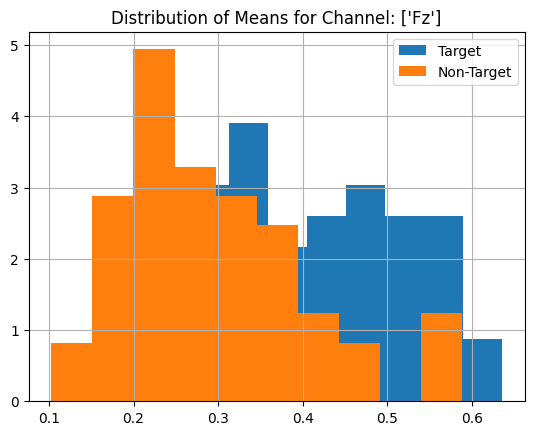

Target Mean: 0.3502991845082773, Std: 0.07561755463373986
Non-Target Mean: 0.23602714700489494, Std: 0.0664550566169918
Confidence interval: ConfidenceInterval(low=np.float64(0.09038736614606521), high=np.float64(inf)), T-Score: 7.945868, Degree of freedom: 96.40932673159442, P-Value: 1.8068513538581769e-12
With a significance level of 0.05000, the hypothesis is rejected


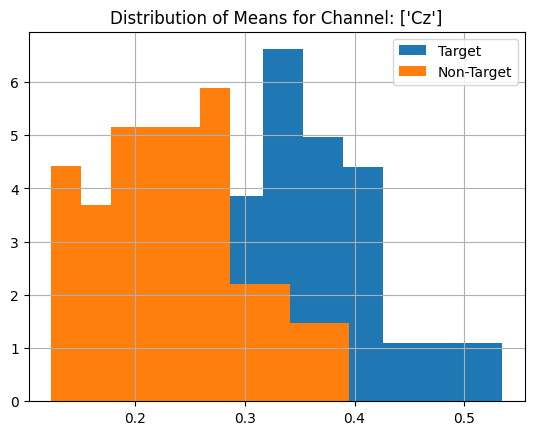

Target Mean: 0.24669367537647346, Std: 0.06536911279072234
Non-Target Mean: 0.229210158831782, Std: 0.04787232034846274
Confidence interval: ConfidenceInterval(low=np.float64(-0.001753837537536631), high=np.float64(inf)), T-Score: 1.510475, Degree of freedom: 89.81838124278941, P-Value: 0.06721627605395337
With a significance level of 0.05000, the hypothesis is accepted


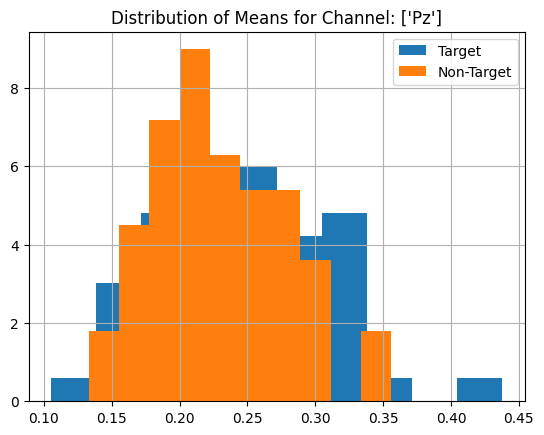

Target Mean: 0.2854948418586868, Std: 0.06187945204438672
Non-Target Mean: 0.20578649450765368, Std: 0.05091108176430387
Confidence interval: ConfidenceInterval(low=np.float64(0.0606927655285302), high=np.float64(inf)), T-Score: 6.963063, Degree of freedom: 94.49231951033862, P-Value: 2.1899252779393868e-10
With a significance level of 0.05000, the hypothesis is rejected


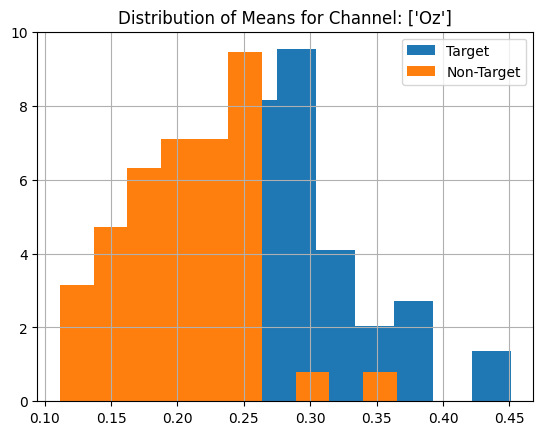

Target Mean: 0.2945102328726267, Std: 0.05732527821801842
Non-Target Mean: 0.22585744574503258, Std: 0.0528878905720921
Confidence interval: ConfidenceInterval(low=np.float64(0.05014940023731625), high=np.float64(inf)), T-Score: 6.161494, Degree of freedom: 97.37068350771845, P-Value: 8.127335245695043e-09
With a significance level of 0.05000, the hypothesis is rejected


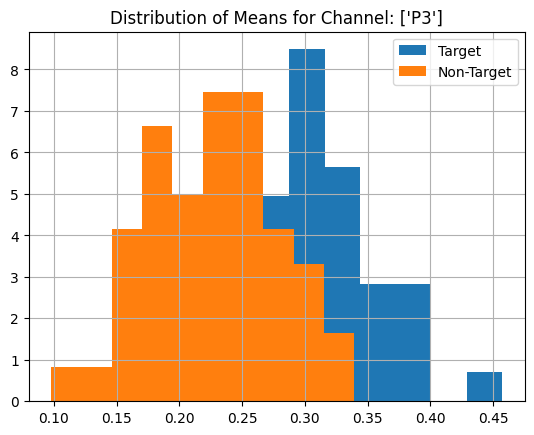

Target Mean: 0.2801090914626462, Std: 0.05612393690885769
Non-Target Mean: 0.22390206512550584, Std: 0.06300989160024492
Confidence interval: ConfidenceInterval(low=np.float64(0.03618750875044339), high=np.float64(inf)), T-Score: 4.662773, Degree of freedom: 96.71613297989596, P-Value: 4.9980154408263555e-06
With a significance level of 0.05000, the hypothesis is rejected


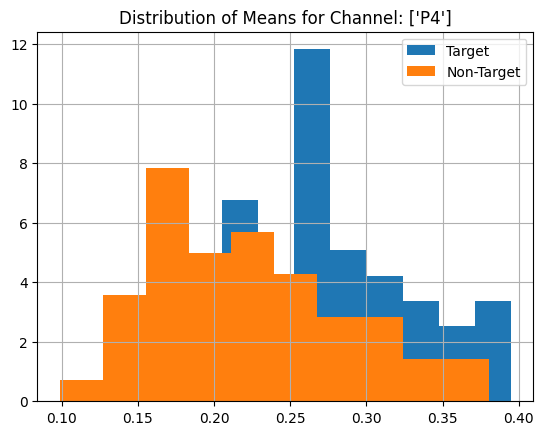

Target Mean: 0.3704199250028131, Std: 0.06760034621658768
Non-Target Mean: 0.24407950848909946, Std: 0.055695340372020646
Confidence interval: ConfidenceInterval(low=np.float64(0.10555522677930304), high=np.float64(inf)), T-Score: 10.097000, Degree of freedom: 94.53921239253765, P-Value: 5.390127936831395e-17
With a significance level of 0.05000, the hypothesis is rejected


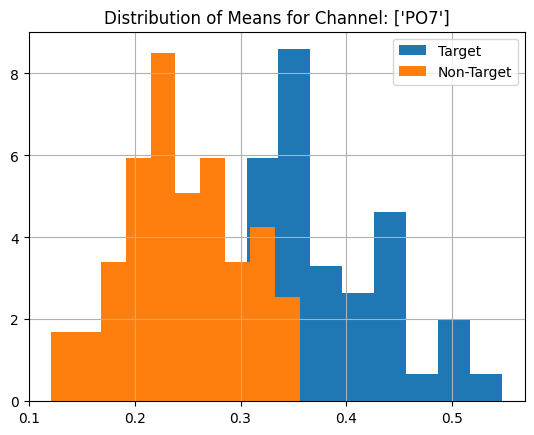

Target Mean: 0.36206553869712665, Std: 0.05470580933861793
Non-Target Mean: 0.2123320823361035, Std: 0.0461726495125699
Confidence interval: ConfidenceInterval(low=np.float64(0.1327469979036772), high=np.float64(inf)), T-Score: 14.641489, Degree of freedom: 95.31074536786855, P-Value: 1.9915727911887795e-26
With a significance level of 0.05000, the hypothesis is rejected


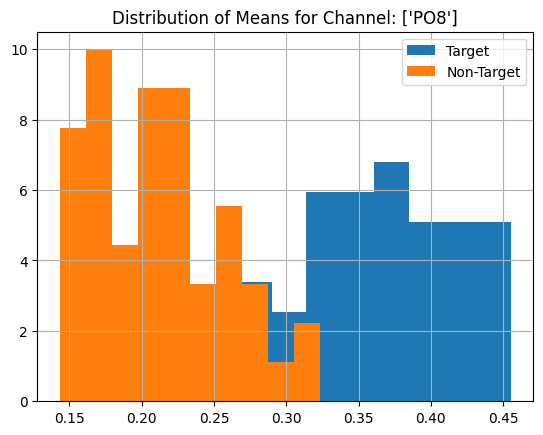

In [18]:
mean_calculation_data_size = 100
sample_size = 50



np.random.seed(34324)

def view_distribution():
    for channel in range(x_target.shape[1]):
        ma_t = []
        ma_nt = []
        for _ in range(sample_size):
            # Get average waveform from sample
            t = np.mean(x_target[ np.random.choice(np.arange(x_target.shape[0]), size=mean_calculation_data_size, replace=False), channel, :], axis=0) 
            nt = np.mean(x_nontarget[ np.random.choice(np.arange(x_nontarget.shape[0]), size=mean_calculation_data_size, replace=False), channel, :], axis=0) 
            
            # Remove negative portion of average waveform as P300 deflection is positive
            t[t<0] = 0
            nt[nt<0] = 0
            
            # Calculate the average amplitude of each signal
            ma_nt.append(np.mean(nt))
            ma_t.append(np.mean(t))

        mean_target_amplitude = np.mean(ma_t)
        std_target_amplitude = np.std(ma_t)
        
        mean_nontarget_amplitude = np.mean(ma_nt)
        std_nontarget_amplitude = np.std(ma_nt)
        
        print(f"Target Mean: {mean_target_amplitude}, Std: {std_target_amplitude}")
        print(f"Non-Target Mean: {mean_nontarget_amplitude}, Std: {std_nontarget_amplitude}")

        # T-Statistics        
        confidence = 0.95
        d = stats.ttest_ind(ma_t, ma_nt, equal_var=False, alternative='greater')
        print(f"Confidence interval: {d.confidence_interval(confidence)}, T-Score: {d.statistic:.6f}, Degree of freedom: {d.df}, P-Value: {d.pvalue}")
        if d.pvalue > (1-confidence):
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is accepted")
        else:
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is rejected")
        


        plt.figure()
        plt.title(f"Distribution of Means for Channel: {get_channel_name(patient_data[0], channel)}")
        plt.hist(ma_t, density=True, label='Target')
        plt.hist(ma_nt, density=True, label='Non-Target')
        plt.grid()
        plt.legend()
        plt.show()
        
        
view_distribution()

Target Mean: 2.3560563478464362, Std: 1.5325400440763912
Non-Target Mean: 2.3686956472651737, Std: 1.4137460967243014
Confidence interval: ConfidenceInterval(low=np.float64(-0.5072844482578301), high=np.float64(inf)), T-Score: -0.042433, Degree of freedom: 97.36888564412634, P-Value: 0.5168799729253004
With a significance level of 0.05000, the hypothesis is accepted


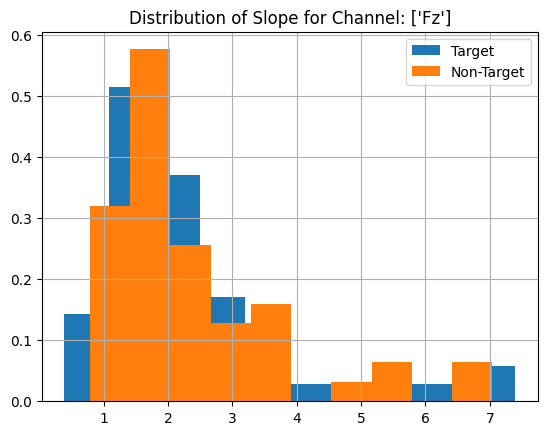

Target Mean: 2.3654364275006294, Std: 0.7604831061059589
Non-Target Mean: 2.110456953040462, Std: 0.832068710299339
Confidence interval: ConfidenceInterval(low=np.float64(-0.01244705129805268), high=np.float64(inf)), T-Score: 1.583384, Degree of freedom: 97.21744440164487, P-Value: 0.05829085416016414
With a significance level of 0.05000, the hypothesis is accepted


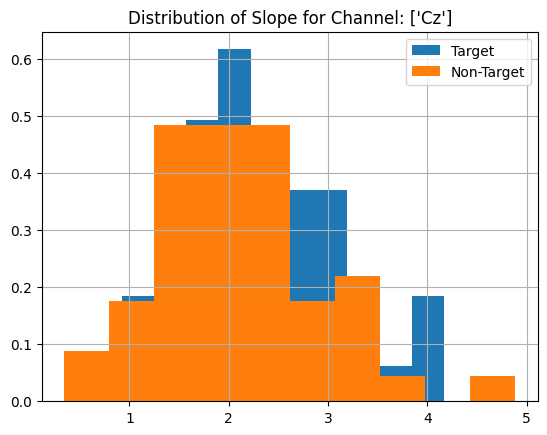

Target Mean: 2.0321738345911, Std: 0.6948777530739522
Non-Target Mean: 2.0279700200033743, Std: 0.6984799430198562
Confidence interval: ConfidenceInterval(low=np.float64(-0.22952024458591655), high=np.float64(inf)), T-Score: 0.029867, Degree of freedom: 97.9973801487747, P-Value: 0.4881169080636207
With a significance level of 0.05000, the hypothesis is accepted


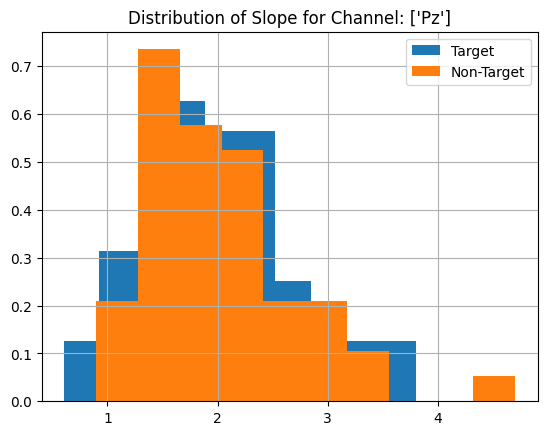

Target Mean: 2.0964359676959496, Std: 0.9098489236362148
Non-Target Mean: 1.9914482090435797, Std: 0.6645209603939243
Confidence interval: ConfidenceInterval(low=np.float64(-0.1625219869261913), high=np.float64(inf)), T-Score: 0.652282, Degree of freedom: 89.69622069013327, P-Value: 0.257943793645949
With a significance level of 0.05000, the hypothesis is accepted


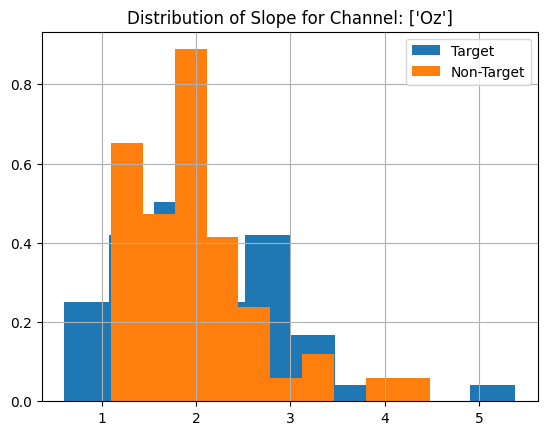

Target Mean: 2.062553656834393, Std: 0.7507022505559855
Non-Target Mean: 2.0583883655151567, Std: 0.7546048260242229
Confidence interval: ConfidenceInterval(low=np.float64(-0.24833734197466462), high=np.float64(inf)), T-Score: 0.027393, Degree of freedom: 97.99736536190501, P-Value: 0.4891011881815549
With a significance level of 0.05000, the hypothesis is accepted


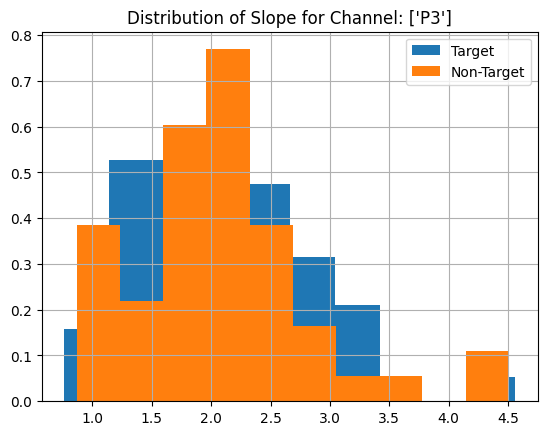

Target Mean: 1.8327308461782141, Std: 0.6159945992478311
Non-Target Mean: 1.8006463245566422, Std: 0.5757768576203542
Confidence interval: ConfidenceInterval(low=np.float64(-0.16794689123194437), high=np.float64(inf)), T-Score: 0.266360, Degree of freedom: 97.55661852988678, P-Value: 0.395262188571335
With a significance level of 0.05000, the hypothesis is accepted


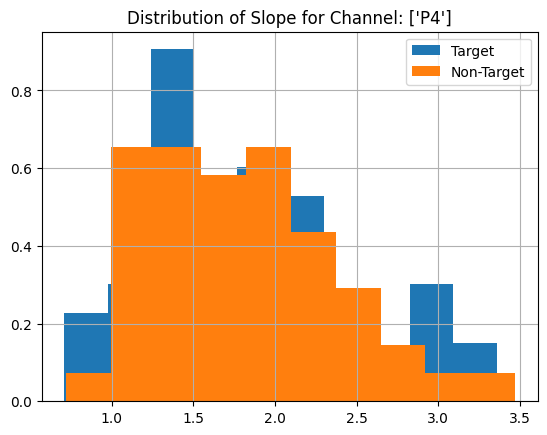

Target Mean: 1.991964474478678, Std: 0.6452274415944829
Non-Target Mean: 1.996294648373353, Std: 0.6585815921414532
Confidence interval: ConfidenceInterval(low=np.float64(-0.22304475699204335), high=np.float64(inf)), T-Score: -0.032876, Degree of freedom: 97.95890231593995, P-Value: 0.5130798965707681
With a significance level of 0.05000, the hypothesis is accepted


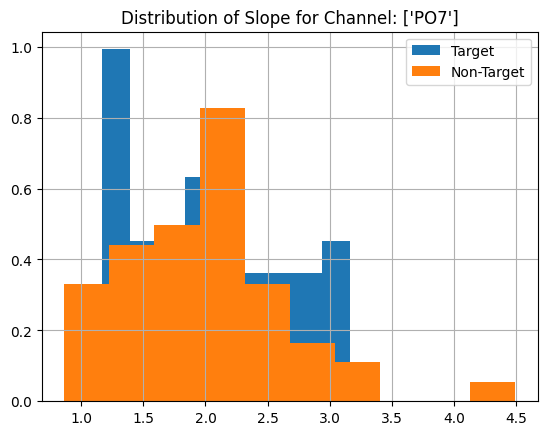

Target Mean: 1.826640843676137, Std: 0.540665124433051
Non-Target Mean: 1.7265234400404856, Std: 0.5797740234696288
Confidence interval: ConfidenceInterval(low=np.float64(-0.08794936568915251), high=np.float64(inf)), T-Score: 0.884036, Degree of freedom: 97.52587063807798, P-Value: 0.18942548788707547
With a significance level of 0.05000, the hypothesis is accepted


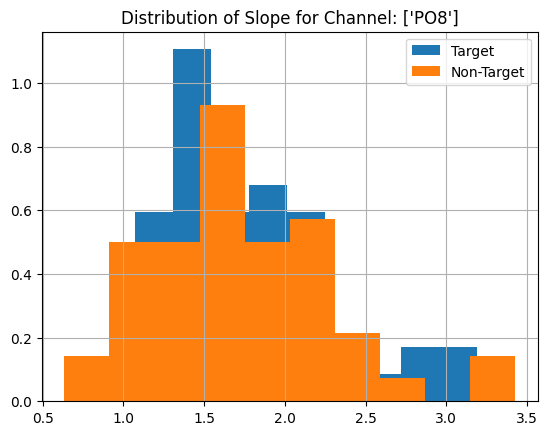

In [19]:
sample_size = 50



np.random.seed(34324)

def view_distribution():
    for channel in range(x_target.shape[1]):
        ma_t = []
        ma_nt = []
        for _ in range(sample_size):
            # Get average waveform from sample
            t = x_target[ np.random.choice(np.arange(x_target.shape[0]), size=1, replace=False), channel, :]
            nt = x_nontarget[ np.random.choice(np.arange(x_nontarget.shape[0]), size=1, replace=False), channel, :] 
            
            # Remove negative portion of average waveform as P300 deflection is positive
            t[t<0] = 0
            nt[nt<0] = 0
            
            # Calculate the average amplitude of each signal
            ma_nt.append(np.mean(nt))
            ma_t.append(np.mean(t))

        mean_target_amplitude = np.mean(ma_t)
        std_target_amplitude = np.std(ma_t)
        
        mean_nontarget_amplitude = np.mean(ma_nt)
        std_nontarget_amplitude = np.std(ma_nt)
        
        print(f"Target Mean: {mean_target_amplitude}, Std: {std_target_amplitude}")
        print(f"Non-Target Mean: {mean_nontarget_amplitude}, Std: {std_nontarget_amplitude}")

        # T-Statistics        
        confidence = 0.95
        d = stats.ttest_ind(ma_t, ma_nt, equal_var=False, alternative='greater')
        print(f"Confidence interval: {d.confidence_interval(confidence)}, T-Score: {d.statistic:.6f}, Degree of freedom: {d.df}, P-Value: {d.pvalue}")
        if d.pvalue > (1-confidence):
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is accepted")
        else:
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is rejected")
        


        plt.figure()
        plt.title(f"Distribution of Slope for Channel: {get_channel_name(patient_data[0], channel)}")
        plt.hist(ma_t, density=True, label='Target')
        plt.hist(ma_nt, density=True, label='Non-Target')
        plt.grid()
        plt.legend()
        plt.show()
        
        
view_distribution()